In [1]:
import pandas as pd
import numpy as np
import feather
from IPython.display import display
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing #Standard Scaler
# import feather
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import (confusion_matrix, accuracy_score)
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
import sklearn.cluster
from scipy.spatial.distance import cdist
%matplotlib inline

from timeit import Timer

In [4]:
df = pd.read_csv('../../data/pea_data_2018-08-28_cleaned.csv', sep=';', decimal=',')

In [5]:
df.columns

Index(['order_weight_min', 'order_weight_aim', 'order_weight_max',
       'customer_order_id', 'production_order_id', 'width', 'thickness',
       'output_weight_target', 'material_sub_type', 'steel_grade_id_int',
       'customer_priority', 'piece_weight_min', 'piece_weight_aim',
       'piece_weight_max', 'rh_mode', 'steel_grade_int_text_en',
       'steel_grade_group_text', 'q2count', 'q3count', 'productionsteps',
       'value_name', 'due_date', 'date_planned_initial_end', 'date_target_end',
       'first_coil_end_date', 'first_coil_released_date',
       'first_coil_delivered_date', 'last_coil_end_date',
       'last_coil_released_date', 'last_coil_delivered_date',
       'total_downgrade_weight', 'hr_downgrade_weight', 'hrp_downgrade_weight',
       'crfh_downgrade_weight', 'crfp_downgrade_weight',
       'crca_downgrade_weight', 'hrgi_downgrade_weight',
       'crgi_downgrade_weight', 'rework_weight', 'lateness'],
      dtype='object')

In [6]:
df.loc[:, ['order_weight_aim',
                'width',
                'thickness',
                'piece_weight_aim',
                "productionsteps"]].reset_index(drop=True)

,order_weight_aim,width,thickness,piece_weight_aim,productionsteps
0,45.359238,1219.199951,7.84860,21.772434,3
1,68.038857,1219.199951,4.59740,21.772434,3
2,113.398094,1524.000000,4.59740,21.772434,3
3,44.769623,1219.199951,6.22300,21.772434,3
4,158.757324,1219.199951,9.44880,21.772434,3
...,...,...,...,...,...
7781,72.574783,1555.750000,2.13360,20.865250,3
7782,17.236509,1476.372437,0.99822,20.865250,4
7783,19.958065,1476.372437,0.99822,20.865250,4
7784,21.772434,1476.372437,0.99822,20.865250,4


In [7]:
X_full = df.loc[:, ['order_weight_aim',
                'width',
                'thickness',
                'piece_weight_aim',
                "productionsteps"]].reset_index(drop=True)

In [8]:
y_full = df.loc[:,'lateness']

In [9]:
borders = [-2880, 2880]

In [10]:
def encode_target_features_to_categorical(target_feature_values, borders):
    """Assign the corresponding integer-valued code to the observable falling
    into the bins defined by borders.

    Args:
        target_feature_values: pandas Series
        borders: borders of intervals the observable must be
            divided in, list of numbers

    Returns:
        observable_encoded: pandas Series
        observable_label: list of symmetric integer-valued codes
            (e.g. [-2, -1, 1, 2])
    """

    n_int = len(borders) + 1
    # print(n_int) 3
    # print(math.ceil(-n_int/2), math.floor(n_int/2) + 1) = -1, 2
    encoded_label_names = [x for x in range(math.ceil(-n_int/2),
                                            math.floor(n_int/2) + 1)]
    # print(encoded_label_names) [-1, 0, 1]
    
    if (n_int % 2 == 0):
        encoded_label_names.remove(0)

    bins = sorted(borders + [-math.inf, +math.inf])
    # print(bins) [-inf, -2880, 2880, inf]
    
    # pd.cut Bin values into discrete intervals.
    encoded_values = pd.cut(target_feature_values,
                            bins=bins,
                            labels=encoded_label_names)
    # y_full.min() = -21980443
    # y_full.max() = 5186653
    # len(y_full[y_full<-2880]) = 5062
    # len(y_full[((y_full>-2880) & (y_full<2880))]) = 19
    # len(y_full[y_full>2880]) = 2705
    # y_full_encoded_values.value_counts()
    # -1    5062
    #  1    2705
    #  0      19
    
    
    return encoded_values, encoded_label_names

In [11]:
(y_full_encoded_values, Y_full_encoded_class_labels) =  encode_target_features_to_categorical(y_full, borders)

In [12]:
# y_full_encoded_values ## lateness
# X_full ## order_weight_aim, width, thickness, piece_weight_aim, productionsteps

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full_encoded_values, test_size=0.1, random_state=100000)

In [14]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
classifier_list = [
    PerformanceEnrichmentAnalysisClassifier(
        number_of_clusters=20, permutations=100),
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()
]

In [18]:
list_of_classifiers = []
list_of_accuracy_scores = []

def train_test_classifier_print_results(clf):
    print(clf.__class__.__name__)
    clf.fit(X_train_scaled, y_train)
    prediction = clf.predict(X_test_scaled)
    cm = confusion_matrix(y_test.values, prediction)
    print("confusion_matrix")
    print(cm)
    print("")

    correct_rate = accuracy_score(y_test.values, prediction)
    correct_count = accuracy_score(y_test.values, prediction, normalize=False)

    print(f"correct rate: {correct_rate}")
    list_of_classifiers.append(clf.__class__.__name__)
    list_of_accuracy_scores.append(correct_rate)
    print(f"correct count: {correct_count}")

In [19]:
for clf in classifier_list:
    t = Timer(lambda: train_test_classifier_print_results(clf))
    print("runtime", t.timeit(number=1))

PerformanceEnrichmentAnalysisClassifier


'DF for PEA:'

,cluster_id,lateness
index,,
0,0,1
160,0,1
171,0,1
183,0,-1
195,0,1
...,...,...
6074,19,1
6249,19,1
6799,19,-1


array([17, 17,  1,  1,  6, 17, 17,  8,  6, 15,  5, 13,  1, 15, 15, 11, 15,
        1, 11, 17, 11,  5,  3, 13,  1, 11, 18, 11, 15, 18, 18, 13, 18,  1,
        1, 17,  8, 15,  1,  3, 17, 15, 10,  1,  3,  1,  3, 11, 18, 13,  6,
        1, 17, 17,  3,  4, 10, 11, 15,  2,  1,  1, 17, 18, 17,  5, 15,  1,
       15, 11, 11, 12, 15, 12,  6, 15,  1,  6,  8,  3, 15,  5, 15,  6, 10,
        7, 18,  1,  3, 16, 11,  1,  1,  3,  5,  3, 15, 11, 17, 15,  1, 14,
       18,  2,  2,  7, 15, 18, 11, 17,  1,  8, 18,  5,  1, 15, 16, 15, 15,
        0, 15,  0,  3, 16,  1, 13,  5, 17, 15, 15, 18, 15,  6, 15,  0,  8,
        6,  7, 13,  2, 17, 10,  5, 15,  3,  3, 15,  3,  3, 15, 11, 17,  1,
        6, 17,  2, 17,  5,  5,  0,  5,  3,  1,  1, 17, 11, 16, 15,  1,  4,
       11,  0,  5,  1, 10, 17,  4,  8,  1, 15, 17,  8, 11,  5, 11,  8, 11,
       11,  8,  1,  7,  7, 17, 17,  0,  2, 13,  3,  8,  2, 11, 16, 18,  5,
        2, 15, 13,  1,  3,  3, 15,  5,  0,  3, 10,  5,  5, 11,  8,  7,  3,
       11,  7, 17, 11,  8

confusion_matrix
[[317   0 191]
 [  1   0   1]
 [136   0 133]]

correct rate: 0.5776636713735558
correct count: 450
runtime 1.1322805329999994


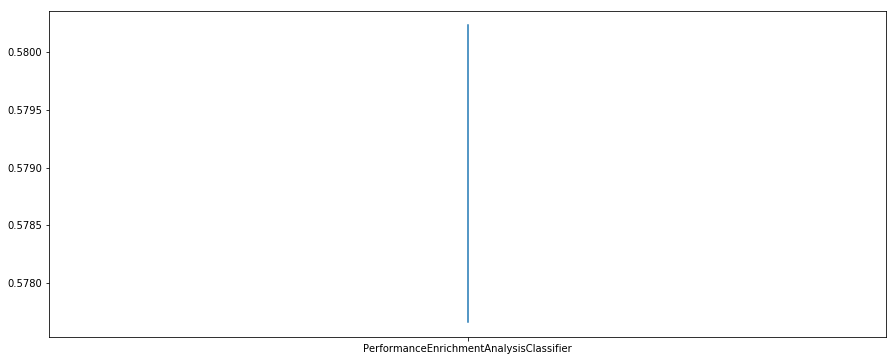

In [21]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,1,1)

ax.plot(list_of_classifiers, list_of_accuracy_scores)

In [21]:
y_full_encoded_values = pd.Series(y_full_encoded_values, name="y_full_encoded_values")

In [22]:
y_full_encoded_values

0      -1
1       1
2      -1
3      -1
4       1
       ..
7781    1
7782    1
7783    1
7784    1
7785    1
Name: y_full_encoded_values, Length: 7786, dtype: category
Categories (3, int64): [-1 < 0 < 1]

In [16]:
class PerformanceEnrichmentAnalysisClassifier():
    
    def __init__(self, cluster_method='KMeans', number_of_clusters=20, permutations=100, random_state=None):
        self.cluster_method = cluster_method
        self.number_of_clusters = number_of_clusters
        self.permutations = permutations
        self.random_state = random_state
        
     # y = kmeans_model.labels_
    def fit(self, X, y, **kwargs):
        if not isinstance(X, pd.DataFrame):
            column_size = X.shape[1]
            columns = [x + str(i) for x, i in zip(["x"]*column_size, range(column_size))]
            X = pd.DataFrame(X, columns=columns)
          
        # display(X)
        if isinstance(y, pd.Series):
            y = y.reset_index(drop=True)
        else:
            y = pd.Series(y, name="y")
         
        # display(y)
        df_result = self._cluster(X)
        df_for_pea = self._prepare_for_pea(df_result, y)
        self.z_score = self._get_pea_z_scores(df_for_pea)
        df_result['z_score'] = self.z_score
        df_result['class_label'] = self.z_score.z_score.apply(lambda x: max(x, key=x.get))
        self.df_result = df_result
        self.y_categories = np.unique(y)
        return self
    
    def predict(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        df_predicted = self._pea_predict(X)
        return df_predicted.values
    
    def _cluster(self, df_train):
        cluster_method_instance = sklearn.cluster.KMeans(n_clusters=self.number_of_clusters)
        c = cluster_method_instance.fit(df_train)
        
        # print('********',c,'********')
        df_result = pd.DataFrame()
        
        df_result["centers_scaled"] = c.cluster_centers_.tolist()
        
        # display(df_result)
        # display('********',c.labels_,'********') ## cluster_id
        
        d = pd.DataFrame(c.labels_, columns=['cluster_id']) \
              .groupby('cluster_id') \
              .indices \
              .items()
        # display('********',d,'********')
        
        df_result['rows'] = [rows for cluster_id, rows in d]
        # display(df_result) ## centers_scaled(cluster centroid), rows(cluster labels)
        
        return df_result
    
    def _prepare_for_pea(self, df_result, target_feature_values_encoded):
        r_series = df_result['rows']
        # display('********',r_series,'********')
        
        rows_in_cluster = [[row, c] for c in range(len(r_series)) for row in r_series[c]]
        # display('********',rows_in_cluster,'********')
        
        rows_in_cluster = pd.DataFrame(rows_in_cluster, columns=['index', 'cluster_id']).set_index('index')
        # display('********',rows_in_cluster,'********') # index, cluster_id
        
        # by default join by index!
        df_for_pea = rows_in_cluster.join(target_feature_values_encoded) # target_feature_values_encoded ~ lateness
        display('DF for PEA:', df_for_pea)        ## Index: index and columns: cluster_id(labels), lateness
        
        return(df_for_pea)

    def _get_pea_z_scores(self, df_for_pea):
        df_for_pea.rename(columns={list(df_for_pea)[1]: 0}, inplace=True)
        # column 'lateness' renamed to 0
        
        # display(df_for_pea[0]) ## leave aside first lateness column and append other shuffled columns from 1 to 100
        for i in range(1, self.permutations + 1):
            df_for_pea[i] = df_for_pea[0].sample(frac=1).reset_index(drop=True)
        
        # display(df_for_pea)
        df_for_pea = df_for_pea.fillna(0)
        
        # print('********',df_for_pea,'********')
        
#         p_count_temp = p_count = pd.melt(df_for_pea,
#                           id_vars=['cluster_id'],
#                           var_name='permutation',
#                           value_name='value')
        
#         display('********',p_count_temp,'********') ## cluster_id, permutation, value
        
        p_count = pd.melt(df_for_pea,
                          id_vars=['cluster_id'],
                          var_name='permutation',
                          value_name='value').astype(int).groupby(['cluster_id',
                                                                   'permutation',
                                                                   'value'])['cluster_id'].count()\
                                                                    .reset_index(name='count')
        
        # display('********',p_count,'********') ## cluster_id, permutation , value, count
        
        # display(p_count.loc[p_count["permutation"] == 0, :])
        
        p_0 = p_count.loc[p_count["permutation"] == 0, :].drop("permutation", axis=1)
        # Remove column permutation where permutation has the value 0
        
        # print('********',p_0,'********')  ## cluster_id, value, count
        
        # for each cluster, for each -1,0 and 1, count the number of rows, find the mean and std, and then merge
        p_count = p_count.groupby(["cluster_id", 'value'])["count"] \
                         .agg(["mean", "std"]) \
                         .reset_index() \
                         .merge(p_0, on=["cluster_id", 'value'], how="left")
        # display('********',p_count,'********') # cluster_id, value, mean, std, count
        
        p_count["z_score"] = (p_count["count"] - p_count["mean"]) / p_count["std"]
        p_count["z_score"] = p_count["z_score"].fillna(0)
        z_score = p_count.drop(["mean", "std", "count"], axis=1) \
                         .pivot(index="cluster_id",
                                columns='value',
                                values="z_score") \
                         .reset_index() \
                         .drop(columns='cluster_id') \
                         .apply(lambda x: x.to_dict(), axis=1) \
                         .rename('z_score') \
                         .to_frame()
        # print(z_score)
        return(z_score)

    def _pea_predict(self, testing_data):
        df_testing_data = pd.DataFrame(testing_data)
        # display(df_testing_data)
        c = self.df_result["centers_scaled"].values
        # display(c) # cluster centroids
        c = np.array([np.array(ci) for ci in c])
        # display(testing_data) # cluster centroids
        # display(cdist(testing_data, c).argmin(axis=1))
        predicted_cluster_id = cdist(testing_data, c).argmin(axis=1)
        display(predicted_cluster_id)
        df_predicted = self.df_result.loc[predicted_cluster_id, "class_label"].reset_index()
        # display(df_predicted)
        return(df_predicted.class_label)

In [23]:
train_test_classifier_print_results(PerformanceEnrichmentAnalysisClassifier(number_of_clusters=20, permutations=100))

PerformanceEnrichmentAnalysisClassifier


'DF for PEA:'

,cluster_id,lateness
index,,
37,0,1
38,0,-1
46,0,-1
50,0,-1
53,0,-1
...,...,...
6504,19,-1
6543,19,1
6551,19,-1


array([ 7,  7,  9, 11, 17,  7,  7,  5, 17,  0,  1,  8,  9,  0,  0, 13,  0,
        9, 13,  7, 13,  1,  3,  8,  9, 13, 12, 13,  0, 12, 12,  8, 12,  9,
        9,  7,  5,  0,  9,  3,  7,  0, 11,  9,  3,  9,  3, 13, 12,  8, 17,
        9,  7,  7,  3,  6, 11, 13,  0,  4,  9,  9,  7, 12,  7,  1,  0,  9,
        0, 13, 13,  2,  0, 13, 17, 14,  9, 17,  5,  3,  0,  1, 14, 17, 11,
       19, 12,  9,  3, 18, 13,  9,  9,  3,  1,  3, 14, 14,  7,  0,  9, 15,
       12,  4,  4, 19, 14, 12, 13,  7,  9, 18, 12,  1,  9,  0, 18,  0,  0,
        5,  0, 18,  3, 18, 11,  8,  1,  7,  0,  0, 12,  0, 17,  0,  5,  5,
       17, 19,  8,  4,  7, 11,  1, 14,  3,  3,  0,  3,  3, 14, 13,  7, 11,
       17,  7,  4,  7,  1,  1,  5,  1,  3, 11,  9,  7, 13, 18,  0,  9,  6,
       13,  5,  1, 11, 11,  7,  6,  5,  9, 14,  7,  5, 13,  1, 13,  5, 13,
       13, 17, 11, 19, 19,  7,  7,  5,  4,  8,  3,  5,  4, 13, 18, 12,  1,
       14, 14,  8, 11,  3,  3,  0,  1, 18,  3, 11,  1,  1, 13, 17, 19,  3,
       13, 19,  7, 13,  5

confusion_matrix
[[319  15 174]
 [  1   0   1]
 [138  15 116]]

correct rate: 0.558408215661104
correct count: 435
